# Deep Neural Network for Image Classification

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from dnn_functions import *

In [2]:
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### Dataset

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


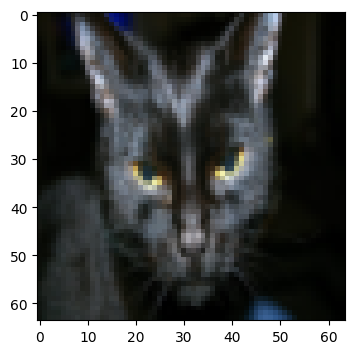

In [4]:
# example of image
idx = 25
plt.imshow(train_x_orig[idx])
print ("y = " + str(train_y[0,idx]) + ". It's a " + classes[train_y[0,idx]].decode("utf-8") +  " picture.")

In [5]:
# dataset dimensions
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print(f'# training observations: {m_train}')
print(f'# test observations: {m_test}')
print(f'Shape of images: {train_x_orig[0].shape}')

# training observations: 209
# test observations: 50
Shape of images: (64, 64, 3)


In [6]:
# image to vector
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# standardize data
train_x = (train_x_flatten/255).T
test_x = (test_x_flatten/255).T

print(f'Train dataset shape: {train_x.shape}')
print(f'Test dataset shape: {test_x.shape}')

Train dataset shape: (12288, 209)
Test dataset shape: (12288, 50)


### Architecture of the model

**2-layer NN:**

In [7]:
# dimensions
n_x = train_x_flatten.shape[1]
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
# model
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)

    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims

    # initialize
    parameters = initialize_parameters(n_x, n_h, n_y)

    # get parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']

    # loop
    for i in range(num_iterations):

        # forward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')

        # cost
        cost = compute_cost(A2, Y)

        # gradient of loss function
        dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))

        # backward propagation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')

        # gradients
        grads['dW1'] = dW1
        grads['dW2'] = dW2
        grads['db1'] = db1
        grads['db2'] = db2

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # get new parameters
        W1 = parameters['W1']
        W2 = parameters['W2']
        b1 = parameters['b1']
        b2 = parameters['b2']

        # print cost
        if (i % 100 == 0) & print_cost:
            print(f'Cost after iteration {i}: {np.squeeze(cost)}')
            costs.append(cost)
        
    
    # plot cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f'Learning rate = {learning_rate}')
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6494146913292486
Cost after iteration 200: 0.6387537015308631
Cost after iteration 300: 0.6286693434056349
Cost after iteration 400: 0.6194882303838515
Cost after iteration 500: 0.6110848881021612
Cost after iteration 600: 0.6033291773062714
Cost after iteration 700: 0.5961181361756855
Cost after iteration 800: 0.5893717998829167
Cost after iteration 900: 0.5830256244823513
Cost after iteration 1000: 0.5770276824473204
Cost after iteration 1100: 0.5713357294506077
Cost after iteration 1200: 0.565914260603773
Cost after iteration 1300: 0.5607341521363022
Cost after iteration 1400: 0.5557699728840423
Cost after iteration 1500: 0.5510008027766723
Cost after iteration 1600: 0.546409089375587
Cost after iteration 1700: 0.541979377583256
Cost after iteration 1800: 0.5376986296324134
Cost after iteration 1900: 0.533555242475195
Cost after iteration 2000: 0.5295405707872312
Cost after iteration 2100: 0.5256440509130453
Cost 

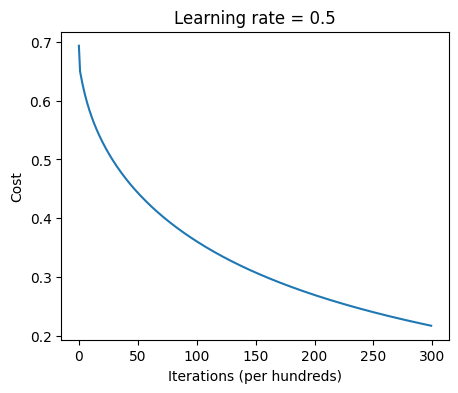

In [9]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), learning_rate=0.5, num_iterations=30000, print_cost=True)

In [10]:
# accuracy in train set
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9665071770334925


In [11]:
# accuracy in test set
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.76


**L-layer NN:**

In [12]:
layers_dims = [12288, 20, 7, 5, 1]

In [13]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []

    # initialize
    parameters = initialize_parameters_deep(layers_dims)

    # loop
    for i in range(0, num_iterations):

        # forward propagation
        AL, caches = L_model_forward(X, parameters)

        # cost
        cost = compute_cost(AL, Y)

        # backward propagation
        grads = L_model_backward(AL, Y, caches)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print cost
        if (i % 100 == 0) & print_cost:
            print(f'Cost after iteration {i}: {np.squeeze(cost)}')
            costs.append(cost)

    # plot cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per hundreds)')
    plt.title(f'Learning rate = {learning_rate}')
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6923799160908503
Cost after iteration 100: 0.6331018172552281
Cost after iteration 200: 0.616797716759388
Cost after iteration 300: 0.6032304970887548
Cost after iteration 400: 0.5918782542026728
Cost after iteration 500: 0.5820262756863995
Cost after iteration 600: 0.5734594959052215
Cost after iteration 700: 0.565497630401718
Cost after iteration 800: 0.5581406172061918
Cost after iteration 900: 0.5511543352746687
Cost after iteration 1000: 0.5445565354510685
Cost after iteration 1100: 0.538354503816428
Cost after iteration 1200: 0.5325746224637156
Cost after iteration 1300: 0.5271203990645515
Cost after iteration 1400: 0.5219228867464832
Cost after iteration 1500: 0.5169494929435373
Cost after iteration 1600: 0.5121662593152323
Cost after iteration 1700: 0.5075737806628183
Cost after iteration 1800: 0.5031121758535992
Cost after iteration 1900: 0.49879891735070664
Cost after iteration 2000: 0.49462846332200555
Cost after iteration 2100: 0.49047568531158364


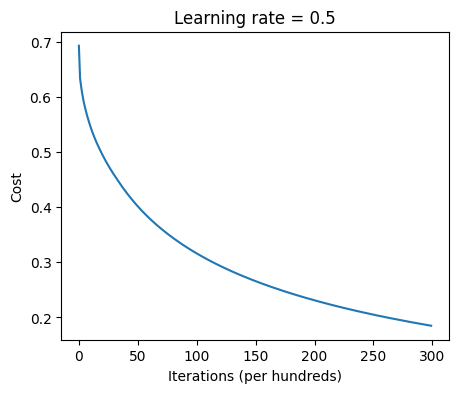

In [14]:
parameters = L_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), learning_rate=0.5, num_iterations=30000, print_cost=True)

In [15]:
# accuracy in train set
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9617224880382773


In [16]:
# accuracy in test set
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.78
